## <font color='darkblue'>Preface</font>

The [previous notebook exercises](https://nbviewer.org/github/johnklee/ml_articles/blob/master/google/Machine_Learning_Crash_Course_with_TensorFlowAPIs/Day1-2_Linear_Regression_with_a_Real_Dataset.ipynb) evaluated the trained model against the training set, which does not provide a strong signal about the quality of your model. <b>In this notebook, you'll experiment with validation sets and test sets</b>. (go/mlclass-colab-validation)

### <font color='darkgreen'>Learning objectives</font>

After doing this notebook, you'll know how to do the following:

  * Split a [training set](https://developers.google.com/machine-learning/glossary/#training_set) into a smaller training set and a [validation set](https://developers.google.com/machine-learning/glossary/#validation_set).
  * Analyze deltas between training set and validation set results.
  * Test the trained model with a [test set](https://developers.google.com/machine-learning/glossary/#test_set) to determine whether your trained model is [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting).
  * Detect and fix a common training problem.

### <font color='darkgreen'>Import relevant modules</font>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


<a id='sect0'></a>
### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'><b><a href='#sect1'>The dataset</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Linear Regression Model</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>Model Evaluation</a></b></font>

<a id='sect1'></a>
## <font color='darkblue'>The dataset</font>

As in the [previous exercise](https://nbviewer.org/github/johnklee/ml_articles/blob/master/google/Machine_Learning_Crash_Course_with_TensorFlowAPIs/Day1-2_Linear_Regression_with_a_Real_Dataset.ipynb), this exercise uses the [California Housing dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) to predict the `median_house_value` at the city block level.  Like many "famous" datasets, the California Housing Dataset actually consists of two separate datasets, each living in separate .csv files:

* The training set is in `california_housing_train.csv`.
* The test set is in `california_housing_test.csv`.

You'll create the validation set by dividing the downloaded training set into two parts:

* a smaller training set  
* a validation set

### <font color='darkgreen'>Load the datasets from the internet</font>

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set.
* `test_df`, which contains the test set.

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

### <font color='darkgreen'>Scale the label values</font>

The following code cell scales the `median_house_value`.

In [3]:
scale_factor = 1000.0

# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

<a id='sect2'></a>
## <font color='darkblue'>Linear Regression Model</font> ([back](#sect0))
* <font size='3ptx'><b><a href='#sect2_1'>Define functions that build and train a model</a></b></font>
* <font size='3ptx'><b><a href='#sect2_2'>Define plotting functions</a></b></font>
* <font size='3ptx'><b><a href='#sect2_3'>Task 1: Experiment with the validation split</a></b></font>
* <font size='3ptx'><b><a href='#sect2_4'>Task 2: Determine why the loss curves differ</a></b></font>
* <font size='3ptx'><b><a href='#sect2_5'>Task 3. Fix the problem</a></b></font>

<a id='sect2_1'></a>
### <font color='darkgreen'>Define functions that build and train a model</font>

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass. 


In [4]:
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        


def train_model(model, df, feature, label, epochs, batch_size, my_validation_split=0.1, verbose=0):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs. 
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=my_validation_split,
                      verbose=verbose)

  # Gather the model's trained weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the 
  # rest of history.
  epochs = history.epoch
  
  # Isolate the root mean squared error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history   

print("Defined the create_model and traing_model functions.")

Defined the create_model and traing_model functions.


<a id='sect2_2'></a>
### <font color='darkgreen'>Define plotting functions</font>
The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  A scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  A loss curve

In [5]:
def plot_the_loss_curve(epochs, mae_training, mae_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  #print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


<a id='sect2_3'></a>
### <font color='darkgreen'>Task 1: Experiment with the validation split</font>
In the following code cell, you'll see a variable named `validation_split`, which we've initialized at 0.2.  The `validation_split` variable specifies the proportion of the original training set that will serve as the <b><font color='darkblue'>validation set</font></b>. The original training set contains 17,000 examples. Therefore, a `validation_split` of 0.2 means that:

* 17,000 * 0.2 ~= 3,400 examples will become the validation set.
* 17,000 * 0.8 ~= 13,600 examples will become the new training set.

The following code builds a model, trains it on the training set, and evaluates the built model on both:

* The training set.
* And the validation set.

**If the data in the training set is similar to the data in the validation set, then the two loss curves and the final loss values should be almost identical. However, the loss curves and final loss values are** *not* **almost identical**. Hmm, that's odd.  

Experiment with two or three different values of `validation_split`.  Do different values of `validation_split` fix the problem? 

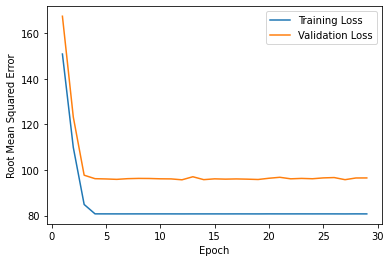

In [6]:
# The following variables are the hyperparameters.
learning_rate = 0.08
epochs = 30
batch_size = 100

# Split the original training set into a reduced training set and a
# validation set. 
validation_split = 0.2

# Identify the feature and the label.
my_feature = "median_income"    # the median income on a specific city block.
my_label = "median_house_value" # the median house value on a specific city block.
# That is, you're going to create a model that predicts house value based 
# solely on the neighborhood's median income.  

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions to build and train the model.
my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, train_df, my_feature, 
                                    my_label, epochs, batch_size, 
                                    validation_split)

plot_the_loss_curve(
  epochs, history["root_mean_squared_error"],  history["val_root_mean_squared_error"])

<a id='sect2_4'></a>
### <font color='darkgreen'>Task 2: Determine **why** the loss curves differ</font>

<b>No matter how you split the training set and the validation set, the loss curves differ significantly. Evidently, the data in the training set isn't similar enough to the data in the validation set</b>. Counterintuitive? Yes, but this problem is actually pretty common in machine learning. 

Your task is to determine **why** the loss curves aren't highly similar. As with most issues in machine learning, the problem is rooted in the data itself. To solve this mystery of why the training set and validation set aren't almost identical, write a line or two of [pandas code](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=validation-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en) in the following code cell.  Here are a couple of hints:

  * The previous code cell split the original training set into:
    * a reduced training set (the original training set - the validation set)
    * the validation set 
  * By default, the pandas [`head`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method outputs the *first* 5 rows of the DataFrame. To see more of the training set, specify the `n` argument to `head` and assign a large positive integer to `n`.

In [7]:
# Examine examples 0 through 4 and examples 25 through 29
# of the training set
train_df.head(n=1000)

# The original training set is sorted by longitude. 
# Apparently, longitude influences the relationship of
# total_rooms to median_house_value.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5
...,...,...,...,...,...,...,...,...,...
995,-117.1,32.5,8.0,6533.0,1217.0,4797.0,1177.0,4.0,144.4
996,-117.1,34.6,6.0,5110.0,1044.0,1938.0,724.0,3.2,112.8
997,-117.1,34.2,22.0,4397.0,931.0,1145.0,445.0,4.5,108.4
998,-117.1,34.0,24.0,4144.0,826.0,2127.0,772.0,2.5,96.0


<a id='sect2_5'></a>
### <font color='darkgreen'>Task 3. Fix the problem</font>

<b>To fix the problem, shuffle the examples in the training set before splitting the examples into a training set and validation set</b>. To do so, take the following steps:

1. Shuffle the data in the training set by adding the following line anywhere before you call `train_model` (in the code cell associated with Task 1):

```
  shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))
```                                    

2. Pass `shuffled_train_df` (instead of `train_df`) as the second argument to `train_model` (in the code call associated with Task 1) so that the call becomes as follows:

```
  epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature, 
                                      my_label, epochs, batch_size, 
                                      validation_split)
```

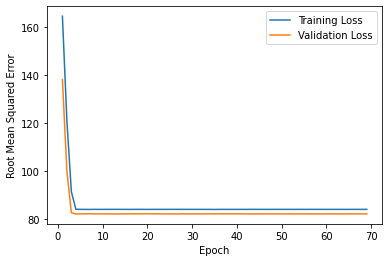

In [8]:
# The following variables are the hyperparameters.
learning_rate = 0.08
epochs = 70
batch_size = 100

# Split the original training set into a reduced training set and a
# validation set. 
validation_split = 0.2

# Identify the feature and the label.
my_feature = "median_income"    # the median income on a specific city block.
my_label = "median_house_value" # the median house value on a specific city block.
# That is, you're going to create a model that predicts house value based 
# solely on the neighborhood's median income.  

# Discard any pre-existing version of the model.
my_model = None

# Shuffle the examples.
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index)) 

# Invoke the functions to build and train the model. Train on the shuffled
# training set.
my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature, 
                                    my_label, epochs, batch_size, 
                                    validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

Experiment with `validation_split` to answer the following questions:

* With the training set shuffled, is the final loss for the training set closer to the final loss for the validation set? 
> Yes, after shuffling the original training set, 
> the final loss for the training set and the 
> validation set become much closer.

* At what range of values of `validation_split` do the final loss values for the training set and validation set diverge meaningfully?  Why?
> If validation_split < 0.15,
> the final loss values for the training set and
> validation set diverge meaningfully.  Apparently,
> the validation set no longer contains enough examples. 

## <font color='darkblue'>Model Evaluation</font> ([back](#sect0))

<a id='sect3'></a>
### <font color='darkgreen'>Task 4: Use the Test Dataset to Evaluate Your Model's Performance</font>

<font size='3ptx'><b>The test set usually acts as the ultimate judge of a model's quality</b></font>. The test set can serve as an impartial judge because its examples haven't been used in training the model. Run the following code cell to evaluate the model with the test set:

In [9]:
X_test = test_df[my_feature]
y_test = test_df[my_label]

results = my_model.evaluate(X_test, y_test, batch_size=batch_size)

30/30 [==============================] - 0s 797us/step - loss: 7010.5708 - root_mean_squared_error: 83.7291


Compare the root mean squared error of the model when evaluated on each of the three datasets:

* training set: look for `root_mean_squared_error` in the final training epoch.
* validation set: look for `val_root_mean_squared_error` in the final training epoch.
* test set: run the preceding code cell and examine the `root_mean_squared_error`.

Ideally, the root mean squared error of all three sets should be similar. Are they?
> In our experiments, yes, the rmse values were similar enough. 